In [10]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
#from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin) :
    """Ансамблевый классификатор с мажоритарным голосованием
    Параметры
    classifiers : под0бен массиву, ф0рма = [n_classifiers]
    Различные классификат0ры для ансамбля.
    vote : str, { 'classlabel ', 'probaЬility'}
    П0 ум0лчанию: 'classlabel '
    В случае 'classlabel' пр0гн0з 0сн0вывается
    на результате argmax мет0к классов. В случае
    'probaЬility' для прогнозирования метки класса
    применяется argmax суммы вероятностей
    (рекомендуется для откалиброванных классификаторов) .
    weights : подобен массиву, форма = [n_classifiers]
    Необязательно, по умолчанию: None
    Если предоставляется список значений int или float,
    тогда классификаторам назначаются веса по важности;
    в случае weights=None используются равномерные веса.
    """
    def __init__(self, classifiers,
                 vote = 'classlabel', weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Подгоняет классификаторы.
        Параметры
        Х : {подобен массиву, разреженная матрица},
        форма = [n_examples, n_features]
        Матрица обучающих образцов .
        у : подобен массиву, форма = [n_examples]
        Вектор целевых меток классов.
        Возвращает
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError('vote должно быть "probability"'
                             f'или "classlabel"; получено (vote = {self.vote})')
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Количество классификаторов и весов должны быть равны'
                             f'Получено {len(self.weights)} весов и {len(self.classifiers)} классификаторов')
        # Использовать LabelEncoder для гарантии того,
        # что метки классов начинаются с О;
        #это важно при вызове np.argmax в self.predict.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                        self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return(self)
    
    def predict(self, X):
        """ Прогнозирует метки классов для Х.
        Параметры

        Х : {подобен массиву, разреженная матрица} ,
        форма = [n_examples, n_features}
        Матрица обучающих образцов.
        Возвращает
        maj_vote : подобен массиву, форма= [n_examples]
        Спрогнозированные метки классов.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis = 1)
        elif self.vote == 'classlabel':
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                                            lambda x:
                                            np.argmax(np.bincount(x,
                                                                weights=self.weights)),
                                            axis=1,
                                            arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """Прогнозирует вероятности классов для Х.
            Параметры
            Х : {подобен массиву, разреженная матрица},
            форма = [n_examples, n_features}
            Обучающие векторы, где п examples - количество
            образцов, а п features - количество признаков.
            Возвращает
            avg_proba : подобен массиву,
            ",,"
            форма_= [n_examples, n_classes]
            Взвешенная усредненная вероятность
            для каждого класса на образец."""
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0,
                               weights=self.weights)
        return avg_proba
    
    def get_params(self, deep: bool = True):
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()

In [12]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.5,
                                                   random_state=1, stratify=y)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', C=0.001,
                          solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Логистическая регрессия', 'Дерево принятия решений', 'KNN']
print('Перекрестная проверка по 10 блокам:')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv = 10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean()} +/- {scores.std()} [{label}]')

Перекрестная проверка по 10 блокам:
ROC AUC: 0.9166666666666666 +/- 0.1536590742882148 [Логистическая регрессия]
ROC AUC: 0.8666666666666668 +/- 0.18333333333333332 [Дерево принятия решений]
ROC AUC: 0.85 +/- 0.13333333333333333 [KNN]


In [14]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)
clf_labels += ['Мажоритарное голосование']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean()} +/- {scores.std()} [{label}]')
    

ROC AUC: 0.9166666666666666 +/- 0.1536590742882148 [Логистическая регрессия]
ROC AUC: 0.8666666666666668 +/- 0.18333333333333332 [Дерево принятия решений]
ROC AUC: 0.85 +/- 0.13333333333333333 [KNN]
ROC AUC: 0.9833333333333334 +/- 0.04999999999999999 [Мажоритарное голосование]


In [15]:
y_test

array([1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1,
       1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 1, 2, 1, 1, 1])

(-0.1, 1.1)

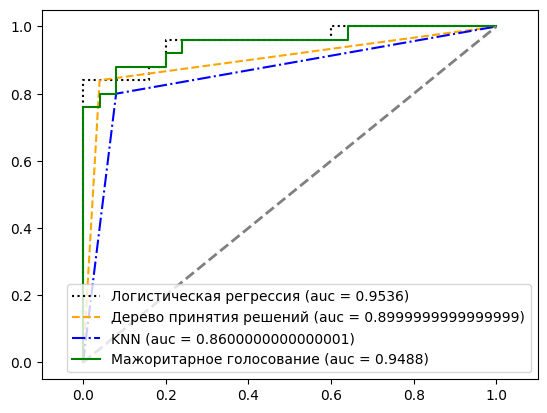

In [16]:
from sklearn.metrics import roc_curve
from sklearn .metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
# предполагается, что меткой положительного класса является 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test - 1, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, 
             label=f'{label} (auc = {roc_auc})')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])

Text(-12.5, 4.5, 'Длина лепестка [стандартизированная]')

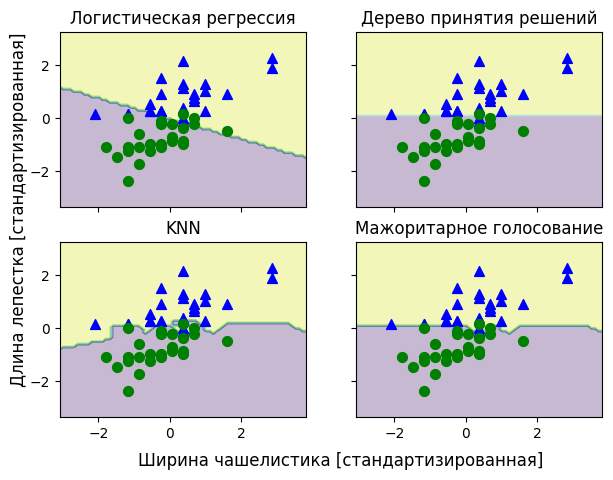

In [17]:
sc = StandardScaler ()
Х_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = Х_train_std[:, 0].min() - 1
x_max = Х_train_std[:, 0].max() + 1
y_min = Х_train_std[:, 1].min() - 1
y_max = Х_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize= (7, 5))
for idx, clf, tt in zip(product ([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(Х_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(Х_train_std[y_train==2, 0],
                                  Х_train_std[y_train==2, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(Х_train_std[y_train==1, 0],
                              Х_train_std[y_train==1, 1],
                              c='green',
                              marker='o',
                              s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5.,
         s='Ширина чашелистика [стандартизированная]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Длина лепестка [стандартизированная]',
         ha='center', va='center',
         fontsize=12, rotation=90)


In [18]:
print(mv_clf.get_params())

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                ['clf', LogisticRegression(C=0.001, random_state=1)]]), 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1), 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                ['clf', KNeighborsClassifier(n_neighbors=1)]]), 'pipeline-1__memory': None, 'pipeline-1__steps': [('sc', StandardScaler()), ['clf', LogisticRegression(C=0.001, random_state=1)]], 'pipeline-1__verbose': False, 'pipeline-1__sc': StandardScaler(), 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1), 'pipeline-1__sc__copy': True, 'pipeline-1__sc__with_mean': True, 'pipeline-1__sc__with_std': True, 'pipeline-1__clf__C': 0.001, 'pipeline-1__clf__class_weight': None, 'pipeline-1__clf__dual': False, 'pipeline-1__clf__fit_intercept': True, 'pipeline-1__clf__intercept_scaling': 1, 'pipeline-1__clf__l1_ratio': None, 'pipeline-1__clf__max_iter': 100, 'pipeline-1__clf__multi_class': 'auto', '

In [19]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth' : [1, 2],
          'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=1),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [20]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print(f"{grid.cv_results_['mean_test_score'][r]} +/- {grid.cv_results_['std_test_score'][r]}, {grid.cv_results_['params'][r]}")

0.9833333333333334 +/- 0.04999999999999999, {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.9833333333333334 +/- 0.04999999999999999, {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.9666666666666668 +/- 0.09999999999999998, {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.9833333333333334 +/- 0.04999999999999999, {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.9833333333333334 +/- 0.04999999999999999, {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.9666666666666668 +/- 0.09999999999999998, {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [21]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}

In [22]:
grid.best_score_

0.9833333333333334

In [23]:
#бэггинг - то же самое что взвешенное голосование, но для обучения производится выборка с возвращением

In [62]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
'machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Метка класса', 'Алкоголь' ,
'Яблочная кислота', 'Зола',
'Щелочность золы',
'Магний', 'Всего фенолов',
'Флавоноиды' , 'Нефлавоноидные фенолы' ,
'Проантоцианидины' ,
'Интенсивность цвета', 'Оттенок',
'00280/00315 разбавленных вин',
'Пролин']
df_wine = df_wine[df_wine['Метка класса'] != 1]
y = df_wine['Метка класса'].values
X = df_wine[['Алкоголь',
            '00280/00315 разбавленных вин']].values

In [63]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2,
                     random_state=1,
                     stratify=y)


In [64]:
from sklearn.ensemble import BaggingClassifier
tree_clf = DecisionTreeClassifier(criterion='entropy',
                              random_state=1)
bag = BaggingClassifier(base_estimator=tree_clf,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [65]:
from sklearn.metrics import accuracy_score
tree_clf = tree_clf.fit(X_train, y_train)
y_train_pred = tree_clf.predict(X_train)
y_test_pred = tree_clf.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Меры правильности дерева при обучении/испытании {tree_train}/{tree_test}')

Меры правильности дерева при обучении/испытании 1.0/0.8333333333333334


In [69]:
#ПЕРЕОБУЧЕНИЕ!!!!!!

In [70]:
bag = bag.fit(X_train, y_train)
y_test_pred = bag.predict(X_test)
y_train_pred = bag.predict(X_train)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Меры правильности дерева при обучении/испытании {bag_train}/{bag_test}')

c:\Users\VIKTOR\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Меры правильности дерева при обучении/испытании 1.0/0.9166666666666666


TypeError: Shapes of y (45, 54) and z (67, 70) do not match

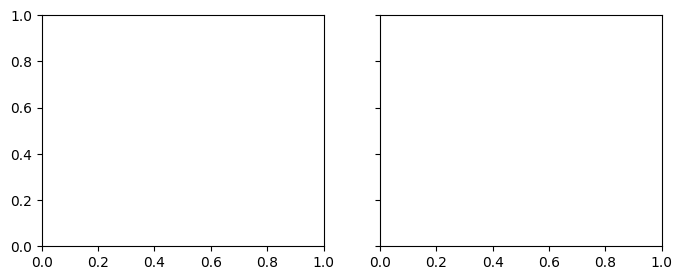

In [72]:
x_min = X_train[:, 0].min () - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train [:, 1].max () + 1
хх, уу = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row' ,
                        figsize=(8, 3))
for idx, clf, tt in zip ([0, 1], [tree_clf, bag] ,
                         ['Дерево принятия решений', 'Бэггинг']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, уу, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       с='blue', marker='^')
    axarr[idx] .scatter(X_train[y_train==1, 0],
    X_train[y_train==1, 1],
    с='green', marker='о')
    axarr[idx].set_title(tt)
axarr[0].sеt_уlabel('Алкоголь', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,
        s='00280/00315 разбавленных вин',
        ha='center',
        va='center',
        fontsize=12,
        transform=axarr[1].transAxes)

In [73]:
#если модель недообучена, то бэггинг бесполезен
#самая распространенная модель ансамблевого метода - adaboost

In [74]:
#алгоритм работы адабуст
#выбираем случайный поднабор d1 для обучения классификатора C1
#выбираем d2 для C2 и к нему добавляем 50% неправильно классифицированных из d1
#находим в обучающем наборе d3 по которым расходятся C1 и C2 и применяем их для обучения C3
#объединяем C1 C2 и C3 мажоритарным голосованием
#склонен к переобучению, воизбежании этого больше веса придаетс неправильно классифицированным образцам

In [75]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Меры правильности дерева при обучении/испытании {tree_train}/{tree_test}')

Меры правильности дерева при обучении/испытании 0.9157894736842105/0.875


In [79]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'Меры правильности AdaBoost при обучении/испытании {ada_train}/{ada_test}')

c:\Users\VIKTOR\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Меры правильности AdaBoost при обучении/испытании 1.0/0.9166666666666666
